In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

In [2]:
df = pd.read_csv('labels.csv', index_col=0)

# Appropriate classes for multitype classification

In [3]:
classes = [(0,1), (1, 10), (10, 50), (50, 100), (100, 500), (500, 1000), (1000, 2000),(2000, 11000)]
counts= pd.Series(np.zeros(len(classes), dtype = int),index=classes)

In [4]:
for entry in np.nditer(df.as_matrix()):
    for cl in classes:
        if (entry >= cl[0]) and (entry <= cl[1]):
            counts[cl] += 1    

In [5]:
counts

(0, 1)            154
(1, 10)           782
(10, 50)         2813
(50, 100)         908
(100, 500)       1294
(500, 1000)       529
(1000, 2000)      401
(2000, 11000)     119
dtype: int64

These classes all contain sufficiently many locations.

# Test - Train split and sorting images into libraries

In [14]:
# Requires that data is in
#
# C:/Data/images
#
# And need to create /Data/test
# and /Data/train directories

datadir = os.getcwd() + '/Data'
imagedir = datadir + '/images'
traindir = datadir + '/train'
testdir = datadir + '/test'

In [15]:
for cl in classes:
    test_dirname = testdir + '/' + str(cl[0]) + '_' + str(cl[1])
    train_dirname = traindir + '/' + str(cl[0]) + '_' + str(cl[1])
    if not os.path.exists(test_dirname): os.mkdir(test_dirname)
    if not os.path.exists(train_dirname): os.mkdir(train_dirname)

In [16]:
test_rate = 0.2

In [17]:
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if np.random.random() > test_rate:
            target_dir = traindir
        else:
            target_dir = testdir
            
        entry = df.iloc[i,j]
        
        for cl in classes:
            if (entry >= cl[0]) and (entry <= cl[1]):
                target_dir = target_dir + '/' + str(cl[0]) + '_' + str(cl[1]) + '/'
        
        shutil.copy(imagedir + '/' + str(99-i) + '_' + str(j) +'.png', target_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/data/zsolt/DS_Project/Data/val/1_10/'

# Using the pretrained neural network

In [26]:
from vgg16 import Vgg16

In [127]:
vgg = Vgg16()
batch_size = 100

In [128]:
batches = vgg.get_batches(traindir, batch_size=batch_size)
val_batches = vgg.get_batches(testdir, batch_size=batch_size)
vgg.finetune(batches)

Found 5560 images belonging to 8 classes.
Found 1440 images belonging to 8 classes.


In [41]:
vgg.fit(batches, test_batches, nb_epoch=30)

Epoch 1/10
5560/5560 [==============================] - 1894s - loss: 1.9767 - acc: 0.4239 - val_loss: 1.2079 - val_acc: 0.5674
Epoch 2/10
5560/5560 [==============================] - 1962s - loss: 1.5603 - acc: 0.4984 - val_loss: 1.1344 - val_acc: 0.5889
Epoch 3/10
5560/5560 [==============================] - 1946s - loss: 1.4018 - acc: 0.5176 - val_loss: 1.1179 - val_acc: 0.6028
Epoch 4/10
5560/5560 [==============================] - 1871s - loss: 1.3323 - acc: 0.5311 - val_loss: 1.0842 - val_acc: 0.5840
Epoch 5/10
5560/5560 [==============================] - 1883s - loss: 1.2687 - acc: 0.5455 - val_loss: 1.0092 - val_acc: 0.6194
Epoch 6/10
5560/5560 [==============================] - 1885s - loss: 1.1849 - acc: 0.5536 - val_loss: 1.0658 - val_acc: 0.6062
Epoch 7/10
5560/5560 [==============================] - 1889s - loss: 1.2053 - acc: 0.5588 - val_loss: 1.0313 - val_acc: 0.6083
Epoch 8/10
5560/5560 [==============================] - 1892s - loss: 1.1565 - acc: 0.5651 - val_loss: 1

In [129]:
vgg.model.save_weights('zsolt.h5')
vgg.model.load_weights('zsolt.h5')

# Visualizing results

# Some helper functions first

In [117]:
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    acc=int(10000*np.diag(cm).sum()/float(cm.sum()))/10000.0
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('{}, Accuracy={}'.format(title,acc), fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, ["0-1", "1-10", "10-50", "50-100", "100-500", "500-1000", "1000-2000", "2000<" ], rotation=90, fontsize = 13)
    plt.yticks(tick_marks, ["0-1", "1-10", "10-50", "50-100", "100-500", "500-1000", "1000-2000", "2000<" ], fontsize = 13)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = round(100 * cm[i,j])/100.0
        if normalize == False: text = int(text)
        plt.text(j, i, text, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize = 17)

    #plt.tight_layout()
    plt.ylabel('True label', fontsize = 17)
    plt.xlabel('Predicted label', fontsize = 17)
    
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

In [68]:
val_data = get_data(testdir)
val_classes = val_batches.classes

Found 1440 images belonging to 8 classes.


In [130]:
val_pred_scores1 = vgg.model.predict(val_data, batch_size=batch_size, verbose = 1)

1440/1440 [==============================] - 287s   


In [131]:
val_prediction1 = [val_pred_scores1[i].argmax() for i in range(len(val_pred_scores1))]

In [132]:
cm1 = confusion_matrix(val_classes, val_prediction1, labels = [3,5,2,1,6,0,7,4])

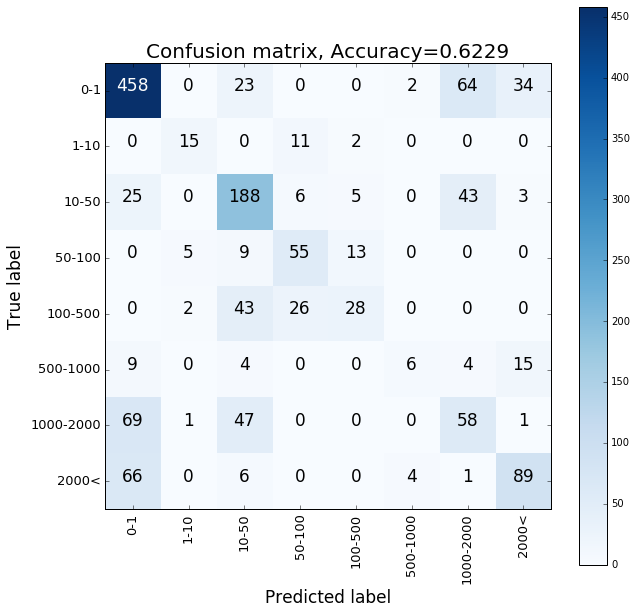

In [133]:
plot_confusion_matrix(cm1, val_batches.class_indices, normalize = False)

# Retraining last two dense layers

Here, we create another vgg model, where instead of just finetuning (i.e. retraining the last layer), we retrain the last two Dense layers.

In [90]:
from keras.layers.core import Dense
from keras.optimizers import SGD, RMSprop, Adam

In [91]:
vgg2 = Vgg16()
batches = vgg2.get_batches(traindir, batch_size=batch_size)
val_batches = vgg2.get_batches(testdir, batch_size=batch_size)
vgg2.finetune(batches)

Found 5560 images belonging to 8 classes.
Found 1440 images belonging to 8 classes.


In [92]:
vgg2.model.load_weights('zsolt.h5')

In [93]:
vgg2.model.layers[-3].trainable = True
#vgg2.model.summary()

In [95]:
vgg2.fit(batches, val_batches, nb_epoch=30)

Epoch 1/30
5560/5560 [==============================] - 1514s - loss: 1.0363 - acc: 0.6155 - val_loss: 1.0119 - val_acc: 0.6111
Epoch 2/30
5560/5560 [==============================] - 1580s - loss: 1.0269 - acc: 0.6088 - val_loss: 1.0556 - val_acc: 0.6160
Epoch 3/30
5560/5560 [==============================] - 1602s - loss: 1.0304 - acc: 0.6147 - val_loss: 0.9631 - val_acc: 0.6236
Epoch 4/30
5560/5560 [==============================] - 1616s - loss: 1.0144 - acc: 0.6142 - val_loss: 1.0185 - val_acc: 0.6215
Epoch 5/30
5560/5560 [==============================] - 1562s - loss: 1.0109 - acc: 0.6200 - val_loss: 1.1266 - val_acc: 0.5632
Epoch 6/30
5560/5560 [==============================] - 1419s - loss: 0.9900 - acc: 0.6234 - val_loss: 1.0208 - val_acc: 0.6299
Epoch 7/30
5560/5560 [==============================] - 1328s - loss: 1.0171 - acc: 0.6189 - val_loss: 1.0367 - val_acc: 0.6201
Epoch 8/30
5560/5560 [==============================] - 1321s - loss: 1.0415 - acc: 0.6131 - val_loss: 1

In [96]:
vgg.model.save_weights('zsolt2.h5')

In [97]:
val_data = get_data(testdir)
val_classes = val_batches.classes

Found 1440 images belonging to 8 classes.


In [98]:
val_pred_scores = vgg2.model.predict(val_data, batch_size=batch_size, verbose = 1)

1440/1440 [==============================] - 263s   


In [99]:
val_prediction = [val_pred_scores[i].argmax() for i in range(len(val_pred_scores))]

In [101]:
cm = confusion_matrix(val_classes, val_prediction, labels = [3,5,2,1,6,0,7,4])

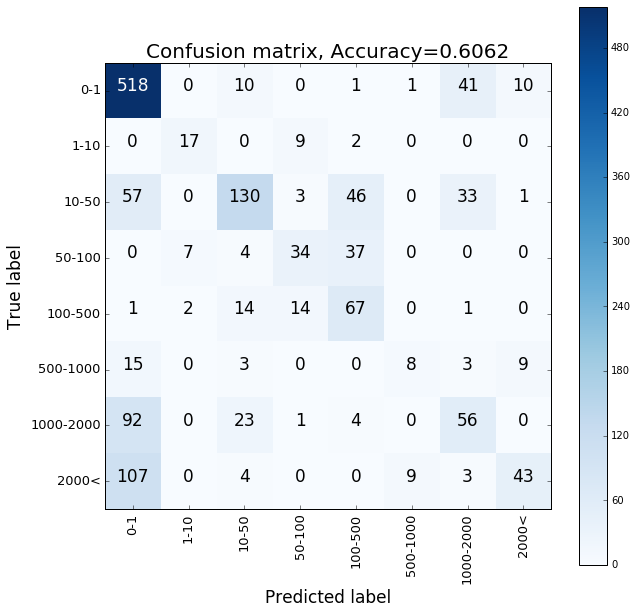

In [118]:
plot_confusion_matrix(cm, val_batches.class_indices, normalize = False)

# Predictions on the test sets

# The East coast test set

In [148]:
test_data_EC = get_data(datadir+'/test1/')
test_batches_EC = vgg.get_batches(datadir+'/test1/', batch_size=batch_size)
test_classes_EC = test_batches_EC.classes

Found 168 images belonging to 8 classes.
Found 168 images belonging to 8 classes.


Using the finetuned VGG:

In [142]:
test_pred_scores_EC1 = vgg.model.predict(test_data_EC, batch_size=batch_size, verbose = 1)
test_prediction_EC1 = [test_pred_scores_EC1[i].argmax() for i in range(len(test_pred_scores_EC1))]
cm_EC1 = confusion_matrix(test_classes_EC, test_prediction_EC1, labels = [3,5,2,1,6,0,7,4])

Found 168 images belonging to 8 classes.
168/168 [==============================] - 33s     


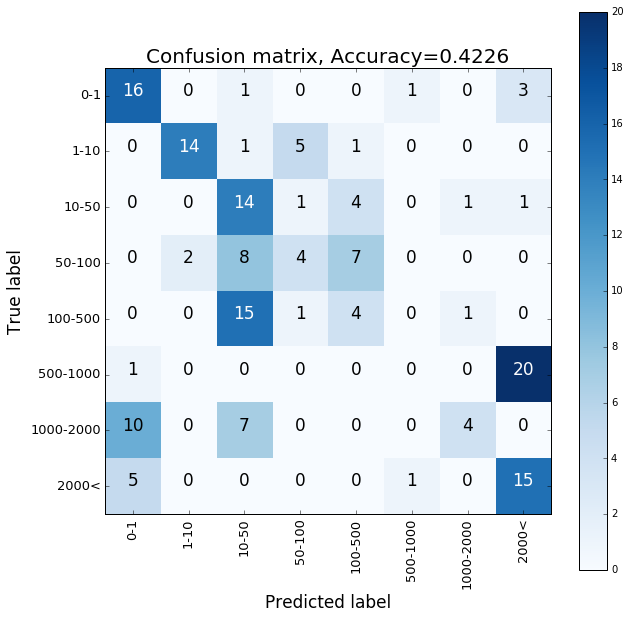

In [144]:
plot_confusion_matrix(cm_EC1, test_batches_EC1.class_indices, normalize = False)

Using the Vgg with retrained layers:

In [149]:
test_pred_scores_EC2 = vgg2.model.predict(test_data_EC, batch_size=batch_size, verbose = 1)
test_prediction_EC2 = [test_pred_scores_EC2[i].argmax() for i in range(len(test_pred_scores_EC2))]
cm_EC2 = confusion_matrix(test_classes_EC, test_prediction_EC2, labels = [3,5,2,1,6,0,7,4])

168/168 [==============================] - 35s     


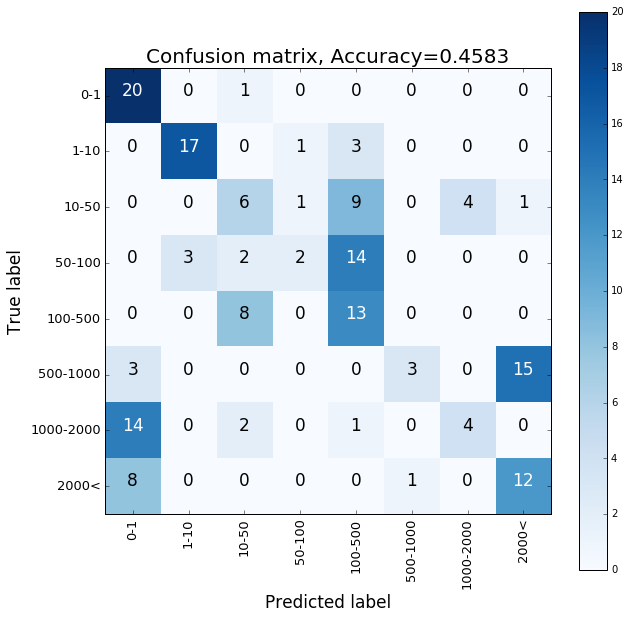

In [150]:
plot_confusion_matrix(cm_EC2, test_batches_EC2.class_indices, normalize = False)

## The west coast test set

In [152]:
test_data_WC = get_data(datadir+'/test2/')
test_batches_WC = vgg.get_batches(datadir+'/test2/', batch_size=batch_size)
test_classes_WC = test_batches_WC.classes

Found 160 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


Using finetuned Vgg:

In [153]:
test_pred_scores_WC1 = vgg.model.predict(test_data_WC, batch_size=batch_size, verbose = 1)
test_prediction_WC1 = [test_pred_scores_WC1[i].argmax() for i in range(len(test_pred_scores_WC1))]
cm_WC1 = confusion_matrix(test_classes_WC, test_prediction_WC1, labels = [3,5,2,1,6,0,7,4])

160/160 [==============================] - 34s     


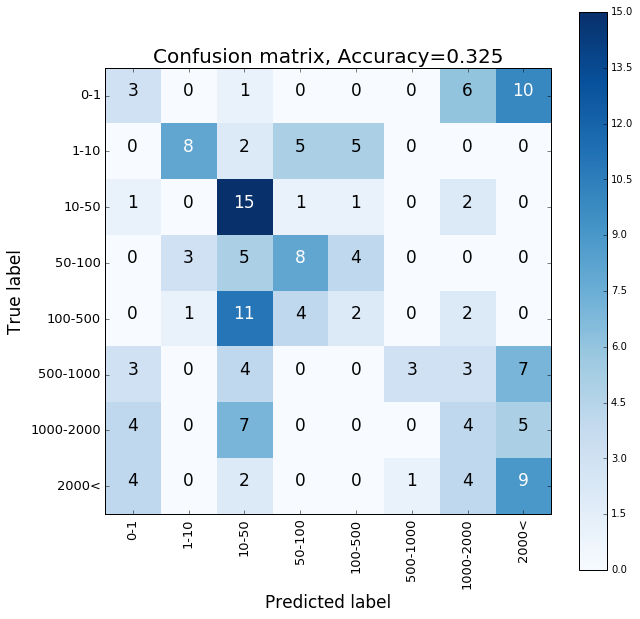

In [154]:
plot_confusion_matrix(cm_WC1, test_batches_EC1.class_indices, normalize = False)

Using Vgg with retrained layer:

In [155]:
test_pred_scores_WC2 = vgg2.model.predict(test_data_WC, batch_size=batch_size, verbose = 1)
test_prediction_WC2 = [test_pred_scores_WC2[i].argmax() for i in range(len(test_pred_scores_WC2))]
cm_WC2 = confusion_matrix(test_classes_WC, test_prediction_WC2, labels = [3,5,2,1,6,0,7,4])

160/160 [==============================] - 32s     


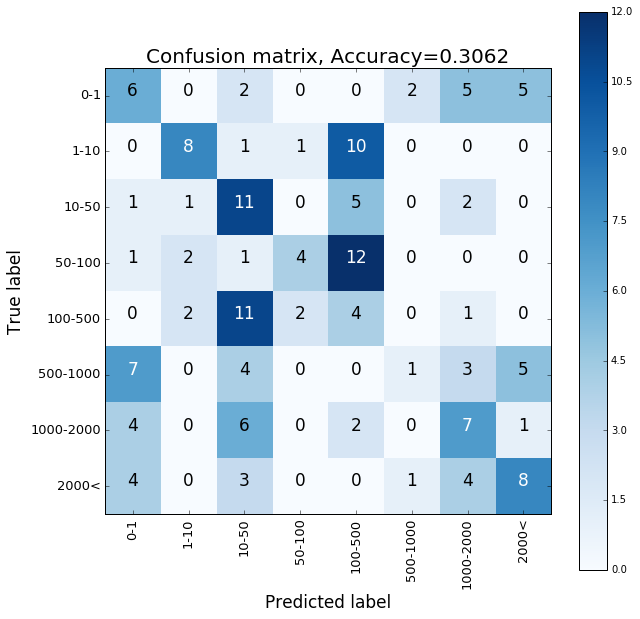

In [157]:
plot_confusion_matrix(cm_WC2, test_batches_WC.class_indices, normalize = False)